In [1]:
import os
import time
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
from tqdm import tqdm
import pickle

from my_policy import Policy     # the RNN
from my_task import CentreOutFF  # the task
from my_loss import cal_loss     # the loss function
from my_utils import *           # misc utility functions

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

Matplotlib is building the font cache; this may take a moment.


All packages imported.
pytorch version: 2.4.0.dev20240529
numpy version: 1.26.4
motornet version: 0.2.0


In [2]:
device = th.device('cpu') # use the cpu not the gpu

# define a two-joint planar arm
# using a Hill-type muscle model as described in
# Kistemaker, Wong & Gribble (2010) J. Neurophysiol. 104(6):2985-94
effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())

# define a task with center-out reaching movements
# also allows for NF or FF or force-channel probe trials
# also includes reaching to random targets in the workspace
# by default 50% no-go catch trials (to help it learn to stay put until the go cue)
env = CentreOutFF(effector=effector, max_ep_duration=1.5)

# define the RNN
n_units = 128
policy = Policy(env.observation_space.shape[0], n_units, env.n_muscles, device=device)

# define the learning rule for updating RNN weights
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [3]:
# make a directory to store the model info

model_name = "my_model"

if (not os.path.exists(model_name)):
    os.mkdir(model_name)

In [4]:
# train the RNN to reach to random targets

n_batch    = 15000  # number of batches to train on 
batch_size =    32  # number of movements in each batch
interval   =  1000  # save progress & plots every so often

# a dictionary to store loss values over training
losses = {
    'overall': [],
    'position': [],
    'muscle': [],
    'muscle_derivative': [],
    'hidden': [],
    'hidden_derivative': [],
    'jerk' : []}

# train!
for batch in tqdm(range(n_batch),
                desc=f"Training {n_batch} batches of {batch_size}",
                unit="batch"):

    # forward pass of all movements in the batch
    data = run_episode(env, policy, batch_size, catch_trial_perc=50, condition='train', ff_coefficient=0.0, detach=False)

    # compute losses
    loss, losses_weighted = cal_loss(data)

    # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()

    # save weights/config/losses
    if (batch % interval == 0) and (batch != 0):
        save_model(env, policy, losses, model_name, quiet=True)
        with open(model_name + "/" + model_name + '_data.pkl', 'wb') as f:
            pickle.dump(data, f)
        print_losses(losses_weighted=losses_weighted, model_name=model_name, batch=batch)
        data, _ = test(model_name + "/" + model_name + "_cfg.json", model_name + "/" + model_name + "_weights")
        plot_stuff(data, model_name + "/" + model_name, batch=batch)

    # Update loss values in the dictionary
    losses['overall'].append(loss.item())
    losses['position'].append(losses_weighted['position'].item())
    losses['muscle'].append(losses_weighted['muscle'].item())
    losses['muscle_derivative'].append(losses_weighted['muscle_derivative'].item())
    losses['hidden'].append(losses_weighted['hidden'].item())
    losses['hidden_derivative'].append(losses_weighted['hidden_derivative'].item())
    losses['jerk'].append(losses_weighted['jerk_loss'].item())

# end of training, save the model and make plots
save_model(env, policy, losses, model_name)
with open(model_name + "/" + model_name + '_data.pkl', 'wb') as f:
    pickle.dump(data, f)
print_losses(losses_weighted=losses_weighted, model_name=model_name, batch=batch)
data, _ = test(model_name + "/" + model_name + "_cfg.json", model_name + "/" + model_name + "_weights")
plot_stuff(data, model_name + "/" + model_name, batch=batch)

Training 15000 batches of 32: 100%|██████████| 15000/15000 [1:08:01<00:00,  3.67batch/s]


saved my_model/my_model_weights
saved my_model/my_model_log.json
saved my_model/my_model_cfg.json


dict_keys(['overall', 'position', 'muscle', 'muscle_derivative', 'hidden', 'hidden_derivative', 'jerk'])


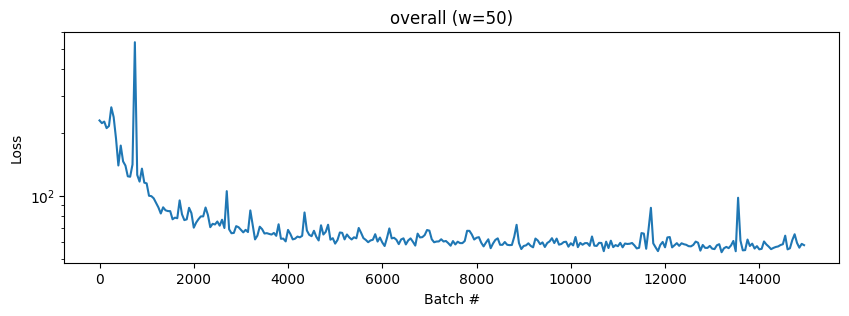

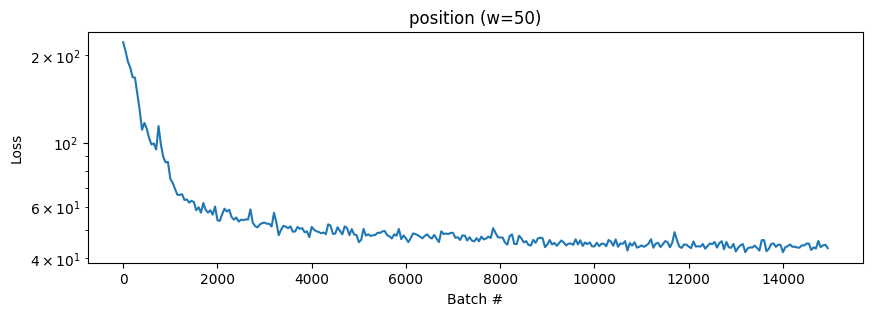

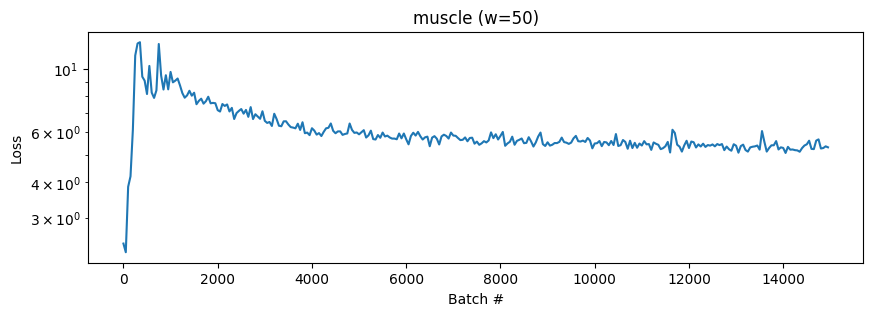

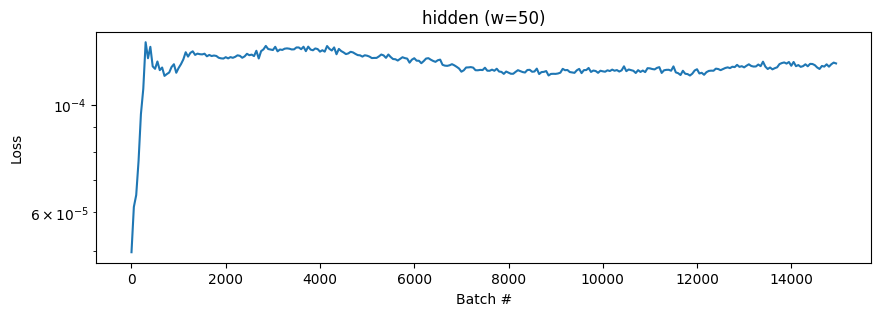

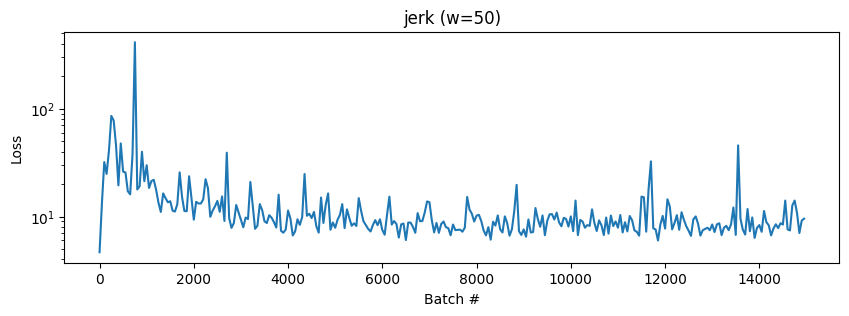

In [5]:
# PLOT LOSS FUNCTION(s)

log = json.load(open(model_name + '/' + model_name + "_log.json",'r'))
print(log["losses"].keys())
w=50
for loss in ["overall","position","muscle","hidden","jerk"]:
    fig,ax = plot_training_log(log=log["losses"],loss_type=loss, w=w)
    ax.set_title(f"{loss} (w={w})")

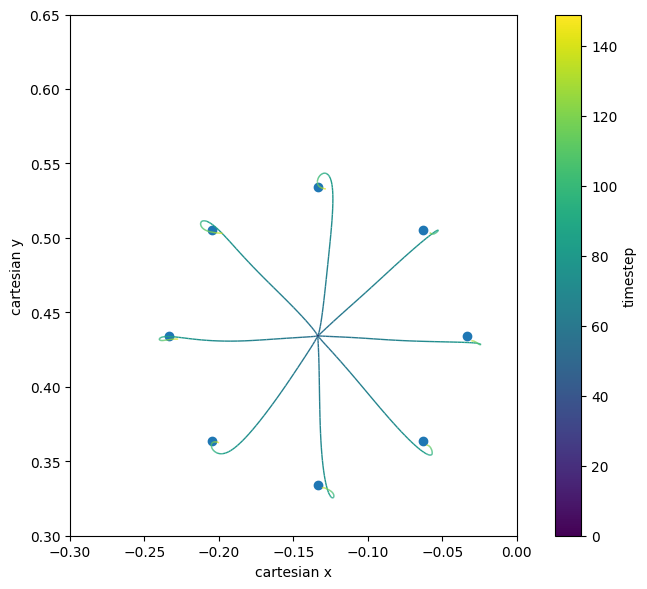

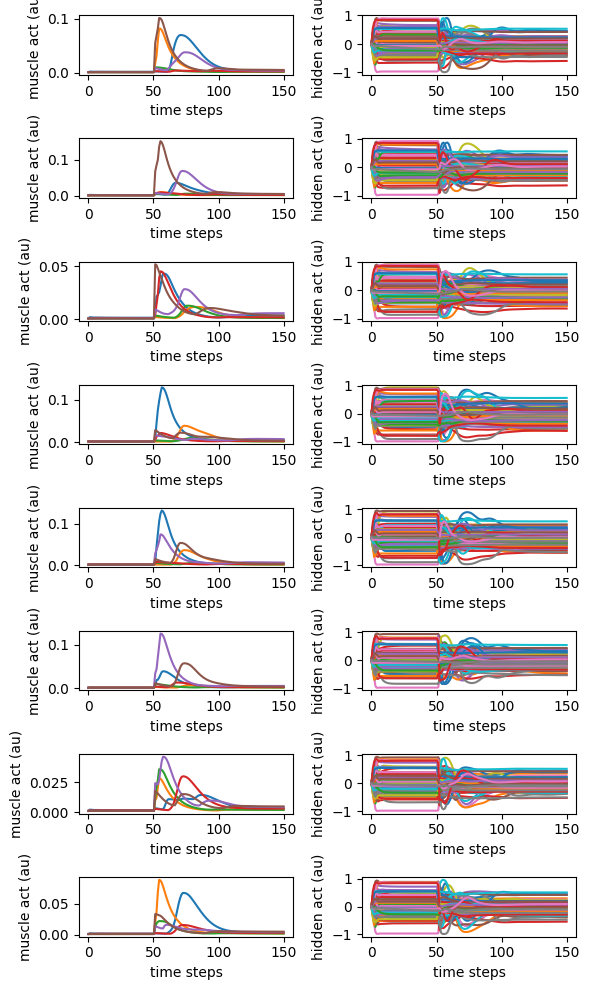

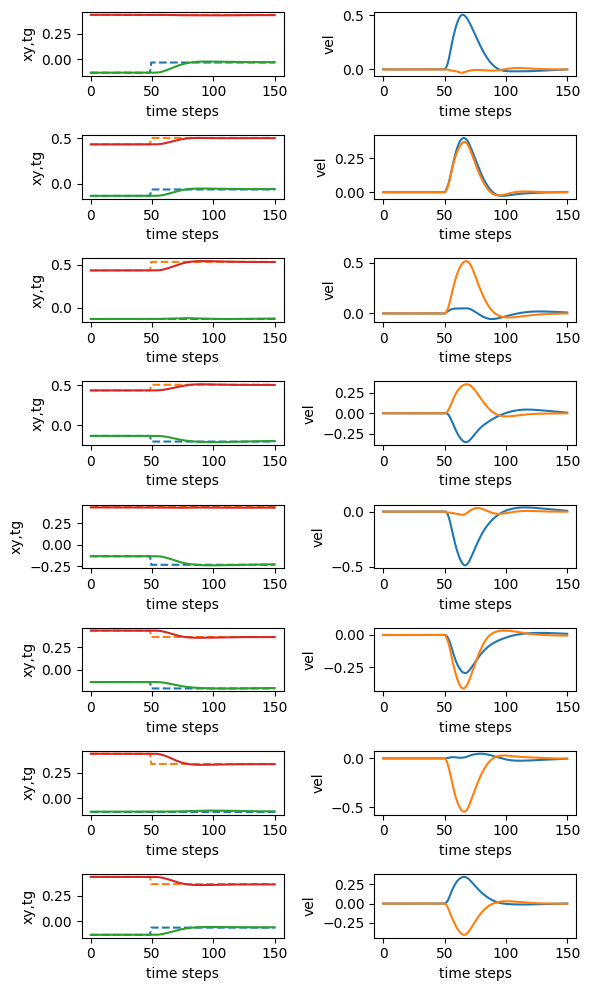

In [6]:
# TEST NETWORK ON CENTRE-OUT

data = test(model_name + '/' + model_name + "_cfg.json", model_name + '/' + model_name + "_weights")[0]
fig, ax = plot_simulations(xy=data['xy'], target_xy=data['tg'], figsize=(8,6))
fig, ax = plot_activation(data['all_hidden'], data['all_muscle'])
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"])